# Deep learning with keras and tensorflow: classification models

*Authors: Evan Carey*

*Copyright 2019-2020, BH Analytics, LLC*

## Overview

We will now turn our attention to implementing classification models using keras. We will  discuss the concept of regularization in deep learning as we fit them, and more broadly tracking training error and generalization error throughout the model training process. Classification also make tracking the error a bit more challenging, as we need to keep track of predicted classes but also predicted probabilities of class membership. 

Here are the topics to cover for this lecture:

- Implementing classification models with keras
- Defining error for classification models
- tracking model performance with validation set
- training error versus generalization error
- plotting divergence of errors over epochs
- regularization options in keras
- l1 and l2 regularization
- model dropout as a form of regularization during fitting

## Libraries

First let's import the libraries we will be using.

In [1]:
import os
import pathlib
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [2]:
## Enable inline plotting for graphics
%matplotlib inline
## Set default figure size to be larger 
## this may only work in matplotlib 2.0+!
matplotlib.rcParams['figure.figsize'] = [10.0,6.0]
## Enable multiple outputs from jupyter cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
## Get Version information
print(sys.version)
print("Pandas version: {0}".format(pd.__version__))
print("Matplotlib version: {0}".format(matplotlib.__version__))
print("Numpy version: {0}".format(np.__version__))
print("Tensorflow version: {0}".format(tf.__version__))
print("Keras version: {0}".format(keras.__version__))

3.8.2 (default, Mar 26 2020, 15:53:00) 
[GCC 7.3.0]
Pandas version: 1.2.4
Matplotlib version: 3.3.4
Numpy version: 1.20.1
Tensorflow version: 2.3.0
Keras version: 2.4.0


 ## SECOM Data

We will use a dataset examining a semi-conductor manufacturing process.The X values are all collected from sensors monitoring the manufacturing process. The outcome is 'fail', a discrete variable with -1 and 1. There are 590 inputs and 1567 rows. 


Here is the reference for the data:

>  Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Check the readme for more details on this dataset. 

First, we import the dataset and do some recoding of the outcome.

In [4]:
# import the dataset
secom_source_X = \
    pd.read_csv(
        r"secom.data",
        delim_whitespace=True,
        header=None)
# changes names
secom_source_X = secom_source_X.add_prefix('X')
secom_source_X.head()
secom_source_X.tail()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X580,X581,X582,X583,X584,X585,X586,X587,X588,X589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X580,X581,X582,X583,X584,X585,X586,X587,X588,X589
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,...,0.0047,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,-0.0061,...,NaN,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,NaN,...,0.0025,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,-0.0072,...,0.0075,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941
1566,2944.92,2450.76,2195.4444,2914.1792,1.5978,100.0,85.1011,0.1235,NaN,NaN,...,0.0045,137.7844,0.4987,0.0181,0.0040,3.6275,0.0117,0.0162,0.0045,137.7844


In [5]:
# import y
secom_source_Y = \
    pd.read_csv(
        r"secom_labels.data",
        delim_whitespace=True,
        header=None)
secom_source_Y.columns = ['Y', 'Date']
# recode Y to be 0/1
secom_source_Y = secom_source_Y.replace(-1, 0)
secom_source_Y.head()

,Y,Date
0,0,19/07/2008 11:55:00
1,0,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,0,19/07/2008 14:43:00
4,0,19/07/2008 15:22:00


Since we have no categorical data, we can just use the `.describe()` method for the X's. 

In [6]:
# Describe all the data
data_description = secom_source_X.describe(include='all').transpose()
data_description.head()

,count,mean,std,min,25%,50%,75%,max
X0,1561.0,3014.452896,73.621787,2743.2400,2966.2600,3011.4900,3056.6500,3356.3500
X1,1560.0,2495.850231,80.407705,2158.7500,2452.2475,2499.4050,2538.8225,2846.4400
X2,1553.0,2200.547318,29.513152,2060.6600,2181.0444,2201.0667,2218.0555,2315.2667
X3,1553.0,1396.376627,441.691640,0.0000,1081.8758,1285.2144,1591.2235,3715.0417
X4,1553.0,4.197013,56.355540,0.6815,1.0177,1.3168,1.5257,1114.5366


We will check for missing as well:

In [7]:
# summarize missing percent by column
miss_per = secom_source_X.isna().sum() / secom_source_X.shape[0]
miss_per.describe()
miss_per

count    590.000000
mean       0.045375
std        0.154340
min        0.000000
25%        0.001276
50%        0.003829
75%        0.005743
max        0.911934
dtype: float64

X0      0.003829
X1      0.004467
X2      0.008934
X3      0.008934
X4      0.008934
          ...   
X585    0.000638
X586    0.000638
X587    0.000638
X588    0.000638
X589    0.000638
Length: 590, dtype: float64

There is a lot of missing data in the inputs! You can explore this further by looking at the `miss_per` object above. We will need to handle the missing data somehow. Francois Chollet (author of 'Deep Learning with Python') recommends one reasonable approach is to put in zero's for all missing data elements after you standardize your data. We will take that approach later in the data cleaning. 

In [8]:
# check the distribution of the outcome
secom_source_Y['Y'].describe()
pd.concat([secom_source_Y['Y'].value_counts(dropna=False),
           secom_source_Y['Y'].value_counts(normalize=True)],
          axis=1)

count    1567.000000
mean        0.066369
std         0.249005
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Y, dtype: float64

,Y,Y
0,1463,0.933631
1,104,0.066369


The outcome is somewhat rare, only occurring 6 percent of the time. This will be a challenge to accurately predict. We will need to think about both actual class predictions (fail yes or no), as well as probability of failure. 

There are a few techniques we can use also to oversample the rare outcome. 

## Convert to numpy objects

We need to end up with numpy X and Y matrices to use as inputs to the keras workflow. There are a number of possible ways to do this. In this case, we have no categorical variables, so it is a bit easier. If there were categorical variables we could use  the `get_dummies()` function from Pandas, although you could also find many other ways to do this. 

In [9]:
# pd.get_dummies()
## create numpy arrays from the target and inputs
Y = secom_source_Y['Y']
X = secom_source_X
Y
X

0       0
1       0
2       1
3       0
4       0
       ..
1562    0
1563    0
1564    0
1565    0
1566    0
Name: Y, Length: 1567, dtype: int64

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X580,X581,X582,X583,X584,X585,X586,X587,X588,X589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,-0.0045,...,0.0047,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720
1563,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,-0.0061,...,NaN,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720
1564,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,NaN,...,0.0025,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231
1565,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,-0.0072,...,0.0075,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941


## Setting up a training/validation/testing dataset

Recall our goal in machine learning in general - to develop an algorithm that minimizes **generalization error**.

However, we can't directly observe **generalization error**, since it is based on out of sample data. 

We need to set up a separate training, validation and testing dataset for our models. We will use the training dataset to train model parameters, then use the the testing dataset to estimate generalization error (instead of training error). I will use a random subset of the data in this case. The validation set will be created during the model fitting calls. 

> Other options can include leveraging time series elements of our data (if present), or leveraging clusters in our data (like stores, or plants, or customers).

We will force the splits to have the same outcome rate using the 'stratify' paramater, which is good practice in classification models. This is especially true of rare outcomes.

In [10]:
from sklearn.model_selection import train_test_split
# initial split - default is to shuffle data and randomly split
X_train, X_test, Y_train, Y_test = \
    train_test_split(X,
                     Y, 
                     train_size=0.8,
                     random_state=4,
                     stratify = Y)
# check dims
print('training data size:', 
      X_train.shape, Y_train.shape)
print('testing data size:',
      X_test.shape, Y_test.shape)
# check outcome frequency
np.mean(Y_train)
np.mean(Y_test)

training data size: (1253, 590) (1253,)
testing data size: (314, 590) (314,)


0.06624102154828412

0.06687898089171974

## Build the first keras model: logistic regression as a NN

We will start with the equivalent model to a logistic regression. The recommended default optimizer to use is `rmsprop`, so we will start there. 

> Notice that I am using the tensorflow.keras module instead of just keras. These are slightly different - tensorflow had imported the keras API into their library. There are minor differences, so this is important to note!

Take a moment to draw the network we are fitting on a piece of paper, and draw out the activation function. Do you see how this is effectively a logistic regression ? 

Also, we are going to examine a broad range of classification metrics here. This is especially important given the imbalance in our data set. Simple accuracy is not a good choice for an outcome that occurs 6% of the time.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# identify metrics of interest - code from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.AUC(name='auc')]

# build a simple linear model using all vars as inputs
def build_model1():
    model = Sequential()
    model.add(Dense(1,
                    activation='sigmoid',
                    input_dim=X_train.shape[1]))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=metrics)
    return model

We will need to scale the training and testing data in a consistent manner. Let's use the sklearn `StandardScaler()` to accomplish this. This will apply the same transformation (based on the initial `.fit()` call) to subsequent datasets. 

We also need to handle the missing data. I will use the `SimpleImputer` from sklearn for this. This will impute the mean; once we standardize the data, the mean will be zero, so we are effectively imputing zero for all the missing data. 

In [12]:
# scale data and impute mean with a transformer so we can later apply the same transformation
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
trans_1 = Pipeline([("impute", SimpleImputer(strategy="mean")),
                      ("scale", StandardScaler())]).fit(X_train)
X_train_s = trans_1.transform(X_train)

Now we can fit the model to the dataset and investigate the results.

In [13]:
# fit this model/architecture to my data
regr1 = build_model1()
regr1.fit(X_train_s,
          Y_train,
          epochs=300,
          validation_split=0.2,
          verbose=0)

We can investigate the model object by asking for the layer weights (just the slope and one weight per input in this model) by asking for the model summary. 

In [14]:
# summarize model
regr1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 591       
Total params: 591
Trainable params: 591
Non-trainable params: 0
_________________________________________________________________


In [15]:
regr1.history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

A good way to understand if the model has converged is to monitor the training error and the validation error for both the loss function, and another sensible metric (accuracy here). 

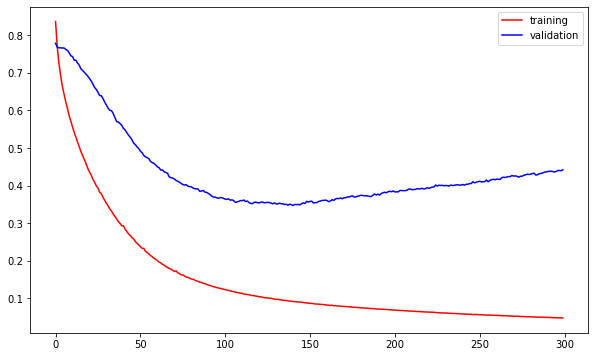

In [16]:
## plot the loss function per epoch
plt.plot(regr1.history.history['loss'],
        color='red',
         label='training')
plt.plot(regr1.history.history['val_loss'],
        color='blue',
         label='validation')
plt.legend()

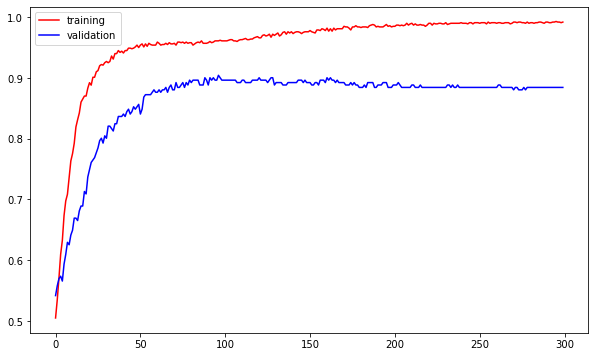

In [17]:
## plot the loss function per epoch
plt.plot(regr1.history.history['accuracy'],
        color='red',
         label='training')
plt.plot(regr1.history.history['val_accuracy'],
        color='blue',
         label='validation')
plt.legend()

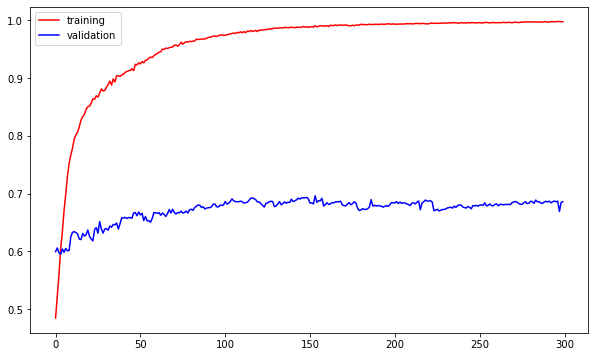

In [18]:
## plot the loss function per epoch
plt.plot(regr1.history.history['auc'],
        color='red',
         label='training')
plt.plot(regr1.history.history['val_auc'],
        color='blue',
         label='validation')
plt.legend()

In [19]:
print('The min validation loss of',
      np.min(regr1.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr1.history.history['val_loss']))

print('The max accuracy of',
      np.max(regr1.history.history['val_accuracy']),
      ',\n was at epoch',
      np.argmax(regr1.history.history['val_accuracy']))

print('The max AUC of',
      np.max(regr1.history.history['val_auc']),
      ',\n was at epoch',
      np.argmax(regr1.history.history['val_auc']))

The min validation loss of 0.34727174043655396 ,
 was at epoch 140
The max accuracy of 0.9043824672698975 ,
 was at epoch 96
The max AUC of 0.6962121725082397 ,
 was at epoch 153


The basic logistic regression seems to overfit the data a lot. The divergence in the validation loss from the training loss indicated we are overfitting the data by the 110th epoch. We likely need to add in some form of regularization, since we have a large number of input variables relative to the output. 

For reference, an AUC value of 0.5 indicates an uninformative model (no better than chance). An AUC of 0.7-0.8 is pretty good discrimination, 0.8-0.9 is very good, and above 0.9 is excellent. So if we stopped training at the 147 epoch, then we would have a not very good model with validaiton AUC of 0.69. 

## LASSO Logistic regression as a NN

We can put an l1 regularizer on this model as we learned in the regression module. This is theoretically identical to a LASSO model. However, in practice, the optimizer for the NN does not allow the parameters to shrink all the way to zero. So even though we expect a sparse model here, we don't end up with one in practice. Instead, we end up with very small weights (but not zero). 

In [20]:
from tensorflow.keras.regularizers import l1
# build a simple linear model with l1 penalty using all vars as inputs
l1_penalty = 0.01


def build_model2():
    model = Sequential()
    model.add(Dense(1,
                    activation='sigmoid',
                    input_dim=X_train.shape[1],
                    kernel_regularizer=l1(l1_penalty)))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=metrics)
    return model

In [21]:
# fit this model/architecture to my data
regr2 = build_model2()
regr2.fit(X_train_s,
          Y_train,
          epochs=300,
          validation_split=0.2,
          verbose=0)

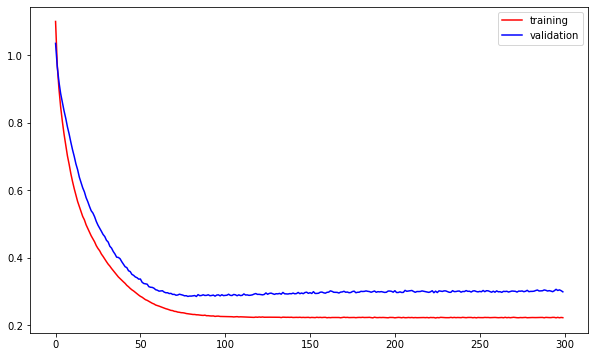

In [22]:
## plot the loss function per epoch
plt.plot(regr2.history.history['loss'],
        color='red',
         label='training')
plt.plot(regr2.history.history['val_loss'],
        color='blue',
         label='validation')
plt.legend()

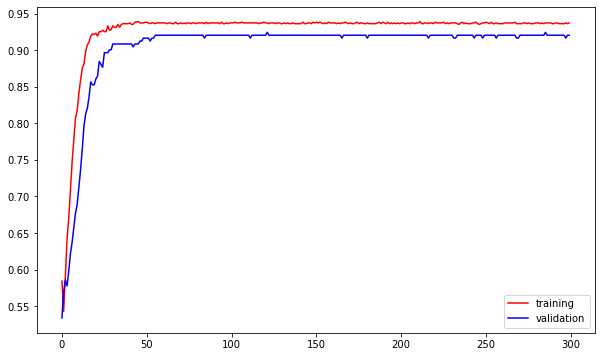

In [23]:
## plot the accuracy function per epoch
plt.plot(regr2.history.history['accuracy'],
        color='red',
         label='training')
plt.plot(regr2.history.history['val_accuracy'],
        color='blue',
         label='validation')
plt.legend()

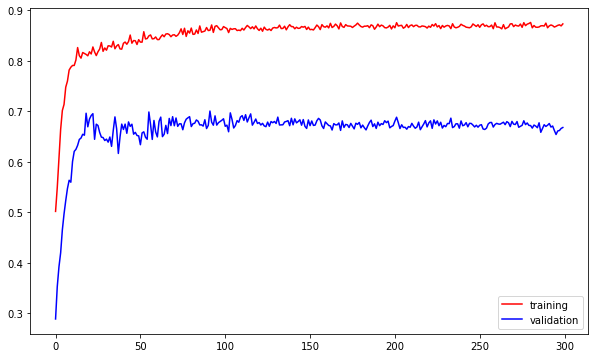

In [24]:
## plot the AUC function per epoch
plt.plot(regr2.history.history['auc'],
        color='red',
         label='training')
plt.plot(regr2.history.history['val_auc'],
        color='blue',
         label='validation')
plt.legend()

In [25]:
print('The min validation loss of',
      np.min(regr2.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr2.history.history['val_loss']))

print('The max accuracy of',
      np.max(regr2.history.history['val_accuracy']),
      ',\n was at epoch',
      np.argmax(regr2.history.history['val_accuracy']))

print('The max AUC of',
      np.max(regr2.history.history['val_auc']),
      ',\n was at epoch',
      np.argmax(regr2.history.history['val_auc']))

The min validation loss of 0.28551018238067627 ,
 was at epoch 83
The max accuracy of 0.9243028163909912 ,
 was at epoch 121
The max AUC of 0.7004328966140747 ,
 was at epoch 91


How good is this model? It is a bit hard to tell without context. Since the event is rare, 92% accuracy is a bit misleading...the event only occurs ~7% of the time, so that is actually not very good. But remember - the accuracy is based on predicted probability > 0.5

The AUC is still about the same max value, but at least we have avoided overfitting in the validation dataset.

Let's look at the predicted probabilities in the training data as well as the observed labels to better understand this model output. 

,predictions,y_observed
377,0.075836,0
1224,0.107410,0
466,0.037030,0
278,0.058430,0
1416,0.014489,0


y_observed
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: predictions, dtype: object

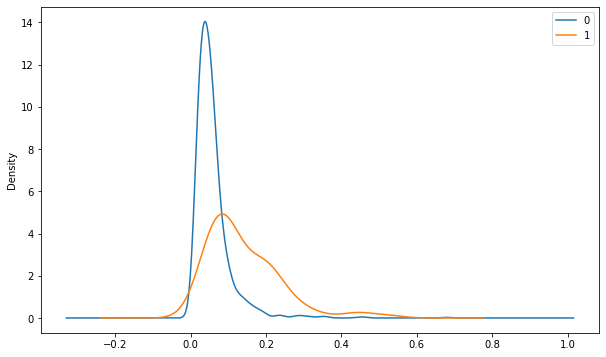

In [26]:
# make pandas dataframe of predicted probabilities and observed classes
df_preds = \
    pd.DataFrame({'predictions': regr2.predict(X_train_s).flatten(),
                  'y_observed': Y_train})
df_preds.head()
# Visualize distribution
df_preds.groupby('y_observed')['predictions'].plot.kde(legend=True)

<AxesSubplot:xlabel='predictions', ylabel='y_observed'>

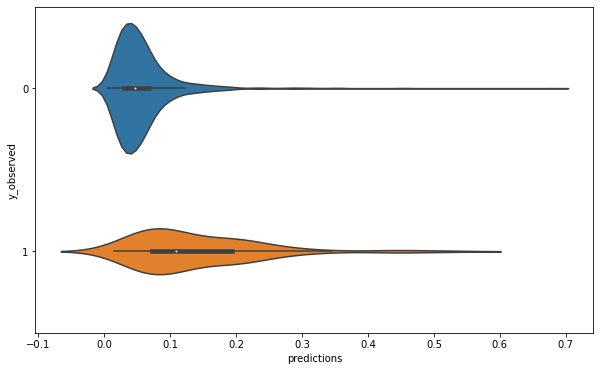

In [27]:
# show probability mass using seaborn
sns.violinplot(y="y_observed", 
               x="predictions",
               data=df_preds,
               orient='h')

<AxesSubplot:xlabel='predictions', ylabel='y_observed'>

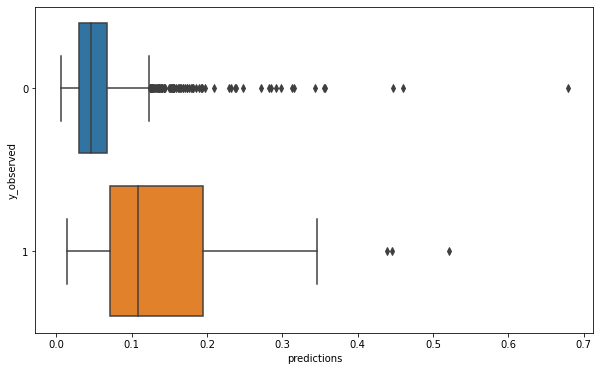

In [28]:
# show using a boxplot
sns.boxplot(y="y_observed", 
               x="predictions",
               data=df_preds,
               orient='h')

We see a bit of differentiation in the training data across the predicted probabilities. However, notice that almost none of the predictions are above 0.5, so almost none of these people will be predicted to have the outcome. Therefore the accuracy won't reflect this variation in predicted probabilities. 

The binary cross-entropy does, but it is harder to interpret. The AUC is probably the best method to use here.

Let's change the penalty strength by increasing it and see what the effect is on the model.

## LASSO Logistic regression as a NN

Here we will increase the magnitude of the penalty a bit.

In [29]:
from tensorflow.keras.regularizers import l1
# build a simple linear model with l1 penalty using all vars as inputs
l1_penalty = 0.05


def build_model3():
    model = Sequential()
    model.add(Dense(1,
                    activation='sigmoid',
                    input_dim=X_train.shape[1],
                    kernel_regularizer=l1(l1_penalty)))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    return model

In [30]:
# fit this model/architecture to my data
regr3 = build_model2()
regr3.fit(X_train_s,
          Y_train,
          epochs=300,
          validation_split=0.2,
          verbose=0)

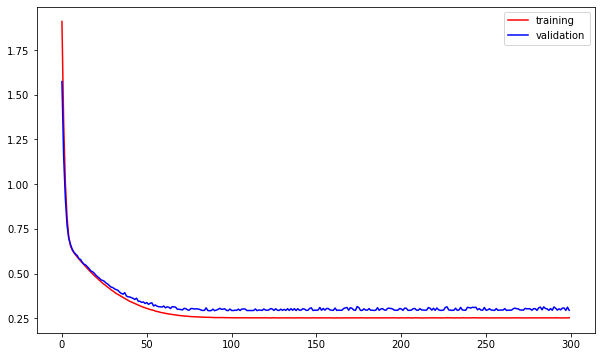

In [31]:
## plot the AUC function per epoch
plt.plot(regr3.history.history['loss'],
        color='red',
         label='training')
plt.plot(regr3.history.history['val_loss'],
        color='blue',
         label='validation')
plt.legend()

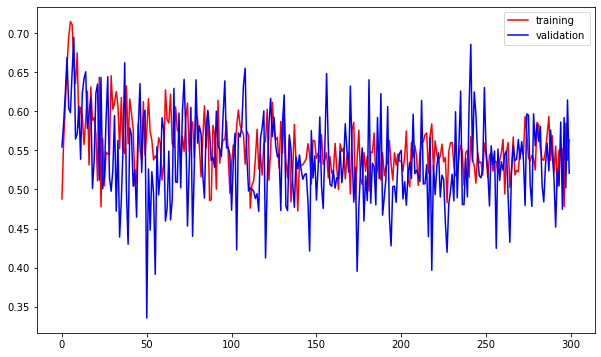

In [32]:
## plot the AUC function per epoch
plt.plot(regr3.history.history['auc'],
        color='red',
         label='training')
plt.plot(regr3.history.history['val_auc'],
        color='blue',
         label='validation')
plt.legend()

In [33]:
print('The min validation loss of',
      np.min(regr3.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr3.history.history['val_loss']))

print('The max accuracy of',
      np.max(regr3.history.history['val_auc']),
      ',\n was at epoch',
      np.argmax(regr3.history.history['val_auc']))

The min validation loss of 0.29193201661109924 ,
 was at epoch 87
The max accuracy of 0.694372296333313 ,
 was at epoch 7


The convergence looks reasonable, but the AUC is terrible. Let's explore the predicted probabilities to better understand the issue:

,predictions,y_observed
377,0.061931,0
1224,0.061847,0
466,0.063130,0
278,0.059986,0
1416,0.062348,0


y_observed
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: predictions, dtype: object

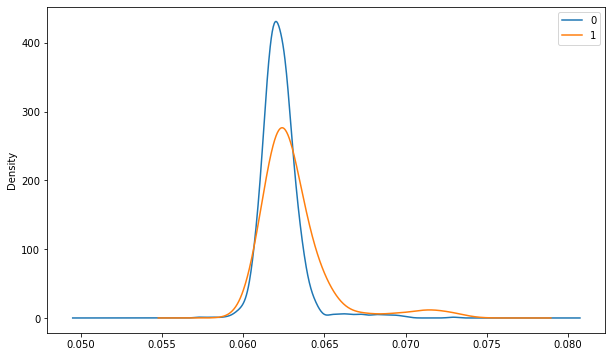

In [34]:
# make pandas dataframe of predicted probabilities and observed classes
df_preds = \
    pd.DataFrame({'predictions': regr3.predict(X_train_s).flatten(),
                  'y_observed': Y_train})
df_preds.head()
# Visualize distribution
df_preds.groupby('y_observed')['predictions'].plot.kde(legend=True)

<AxesSubplot:xlabel='predictions', ylabel='y_observed'>

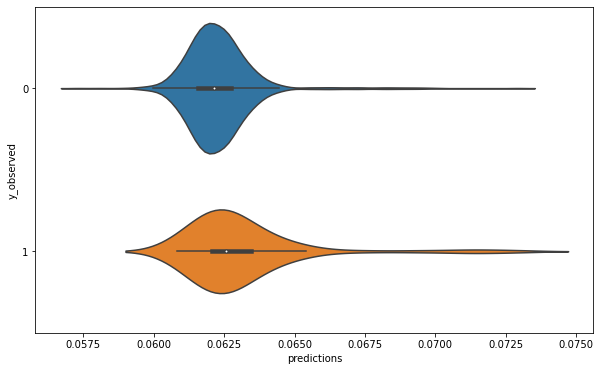

In [35]:
# show probability mass using seaborn
sns.violinplot(y="y_observed", 
               x="predictions",
               data=df_preds,
               orient='h')

<AxesSubplot:xlabel='predictions', ylabel='y_observed'>

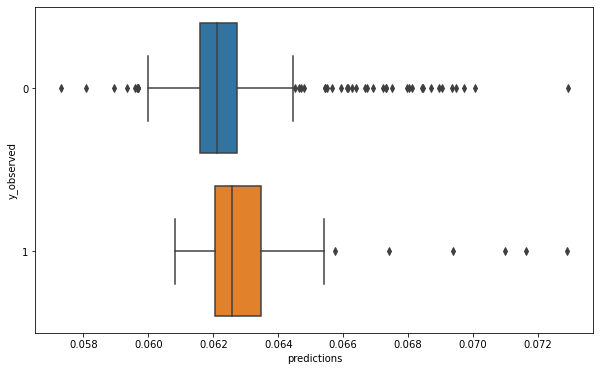

In [36]:
# show using a boxplot
sns.boxplot(y="y_observed", 
               x="predictions",
               data=df_preds,
               orient='h')

It looks like we over penalized the model. The range of prediction probabilities is only from 0.0 to 0.08, and the distribution looks the same across events and non-events. This implies we over penalized the weights. 

## LASSO Logistic regression as a NN, weaker penalty

Let's investigate an even weaker penalty to see what happens. 

In [37]:
from tensorflow.keras.regularizers import l1
# build a simple linear model with l1 penalty using all vars as inputs
l1_penalty = 0.005
def build_model4():
    model = Sequential()
    model.add(Dense(1,
                    activation='sigmoid',
                    input_dim=X_train.shape[1],
                    kernel_regularizer=l1(l1_penalty)))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=metrics)
    return model

In [38]:
# fit this model/architecture to my data
regr4 = build_model4()
regr4.fit(X_train_s,
          Y_train,
          epochs=300,
          validation_split=0.2,
          verbose=0)

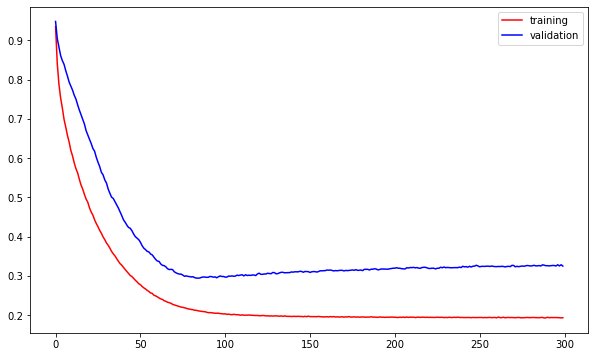

In [39]:
# plot the loss function per epoch
plt.plot(regr4.history.history['loss'],
         color='red',
         label='training')
plt.plot(regr4.history.history['val_loss'],
         color='blue',
         label='validation')
plt.legend()

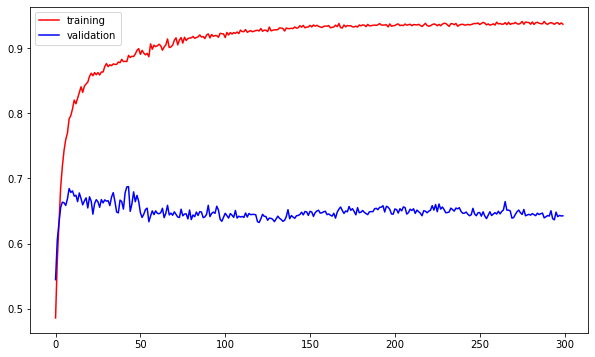

In [40]:
# plot the AUC per epoch
plt.plot(regr4.history.history['auc'],
         color='red',
         label='training')
plt.plot(regr4.history.history['val_auc'],
         color='blue',
         label='validation')
plt.legend()

In [41]:
print('The min validation loss of',
      np.min(regr4.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr4.history.history['val_loss']))

print('The max auc of',
      np.max(regr4.history.history['val_auc']),
      ',\n was at epoch',
      np.argmax(regr4.history.history['val_auc']))

The min validation loss of 0.2941437065601349 ,
 was at epoch 84
The max auc of 0.6873376369476318 ,
 was at epoch 43


,predictions,y_observed
377,0.121110,0
1224,0.198822,0
466,0.008013,0
278,0.090077,0
1416,0.006151,0


y_observed
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: predictions, dtype: object

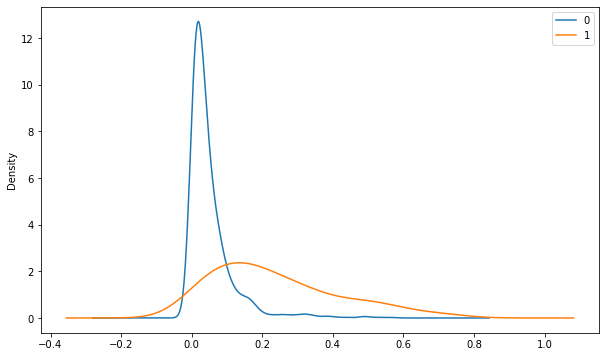

In [42]:
# make pandas dataframe of predicted probabilities and observed classes
df_preds = \
    pd.DataFrame({'predictions': regr4.predict(X_train_s).flatten(),
                  'y_observed': Y_train})
df_preds.head()
# Visualize distribution
df_preds.groupby('y_observed')['predictions'].plot.kde(legend=True)

<AxesSubplot:xlabel='predictions', ylabel='y_observed'>

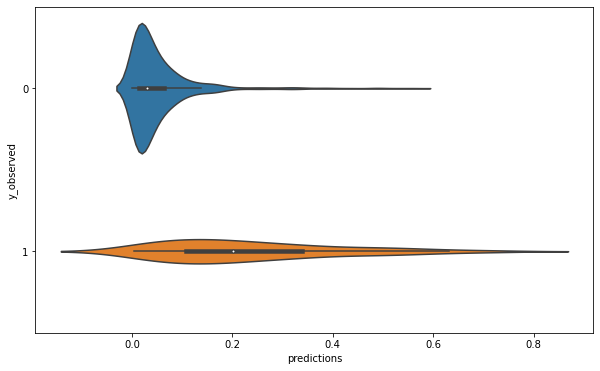

In [43]:
# show probability mass using seaborn
sns.violinplot(y="y_observed", 
               x="predictions",
               data=df_preds,
               orient='h')

<AxesSubplot:xlabel='predictions', ylabel='y_observed'>

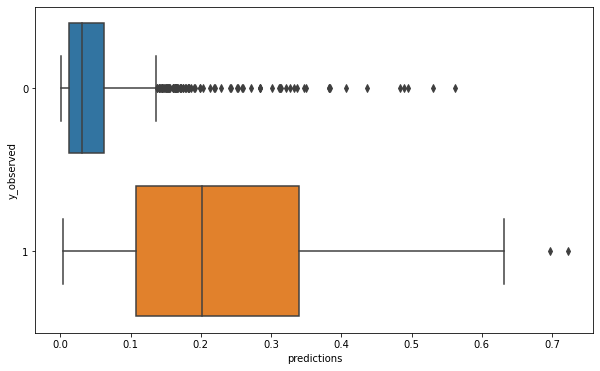

In [44]:
# show using a boxplot
sns.boxplot(y="y_observed", 
               x="predictions",
               data=df_preds,
               orient='h')

We have some separation in the training predictions now. There may be some overfitting as evidenced by the slight divergence in the loss functions between training and validation data per epoch. Let's now explore a deeper model. 

## A deeper NN with regularization

Here we will change the architecture a bit and explore a deeper model. We will add a few hidden layers, and a dropout layer in addition to the L1 regularization term.

In [45]:
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Dropout
# build a simple linear model with l1 penalty using all vars as inputs
l1_penalty = 0.005


def build_model5():
    model = Sequential()
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty),
                    input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty)))
    model.add(Dropout(0.5))
    model.add(Dense(1,
                    activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=metrics)
    return model

In [46]:
# fit this model/architecture to my data
regr5 = build_model5()
regr5.fit(X_train_s,
          Y_train,
          epochs=300,
          validation_split=0.2,
          verbose=0)

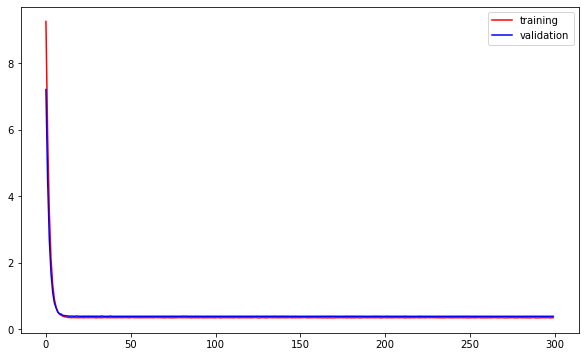

In [47]:
# plot the loss function per epoch
plt.plot(regr5.history.history['loss'],
         color='red',
        label='training')
plt.plot(regr5.history.history['val_loss'],
         color='blue',
        label='validation')
plt.legend()

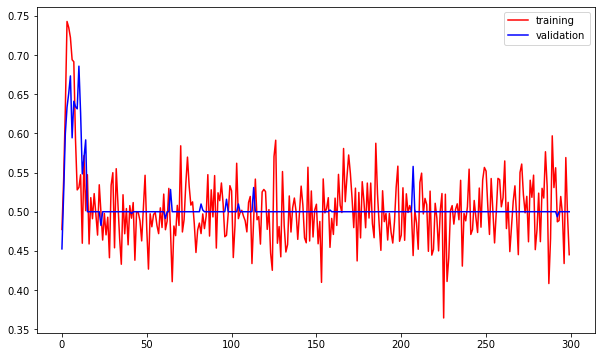

In [48]:
# plot the loss function per epoch
plt.plot(regr5.history.history['auc'],
         color='red',
        label='training')
plt.plot(regr5.history.history['val_auc'],
         color='blue',
        label='validation')
plt.legend()

In [49]:
print('The min validation loss of',
      np.min(regr5.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr5.history.history['val_loss']))

print('The max auc of',
      np.max(regr5.history.history['val_auc']),
      ',\n was at epoch',
      np.argmax(regr5.history.history['val_auc']))

The min validation loss of 0.3828790485858917 ,
 was at epoch 269
The max auc of 0.6857142448425293 ,
 was at epoch 10


,predictions,y_observed
377,0.058648,0
1224,0.058649,0
466,0.058635,0
278,0.058656,0
1416,0.058643,0


y_observed
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: predictions, dtype: object

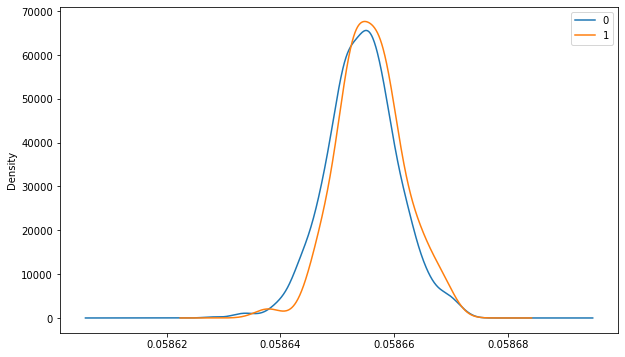

In [50]:
# make pandas dataframe of predicted probabilities and observed classes
df_preds = \
    pd.DataFrame({'predictions': regr5.predict(X_train_s).flatten(),
                  'y_observed': Y_train})
df_preds.head()
# Visualize distribution
df_preds.groupby('y_observed')['predictions'].plot.kde(legend=True)

<AxesSubplot:xlabel='predictions', ylabel='y_observed'>

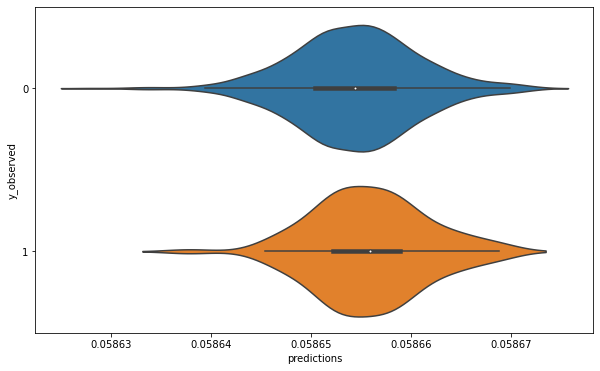

In [51]:
# show probability mass using seaborn
sns.violinplot(y="y_observed", 
               x="predictions",
               data=df_preds,
               orient='h')

<AxesSubplot:xlabel='predictions', ylabel='y_observed'>

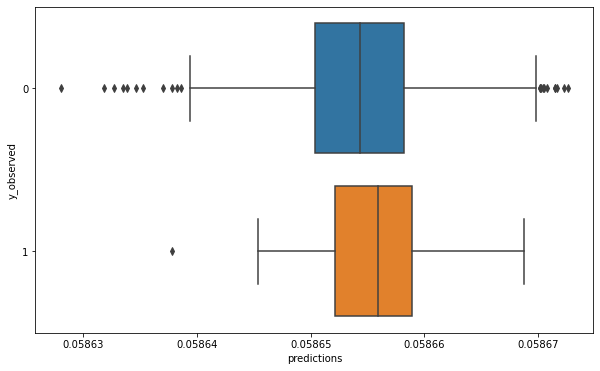

In [52]:
# show using a boxplot
sns.boxplot(y="y_observed", 
               x="predictions",
               data=df_preds,
               orient='h')

This is too much regularization it looks like. We once again have all similar predictions centered around the mean. Let's keep the dropout, but decrease the penalty. 

## A deeper NN with regularization

Here we will change the architecture a bit and explore a deeper model. We will add a few hidden layers, and a dropout layer in addition to the L1 regularization term.

In [53]:
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Dropout

l1_penalty = 0.001


def build_model6():
    model = Sequential()
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty),
                    input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty)))
    model.add(Dropout(0.5))
    model.add(Dense(1,
                    activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=metrics)
    return model

In [54]:
# fit this model/architecture to my data
regr6 = build_model6()
regr6.fit(X_train_s,
          Y_train,
          epochs=300,
          validation_split=0.2,
          verbose=0)

In [55]:
# dir(regr6)
#dir(regr6.history.history)
regr6.history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

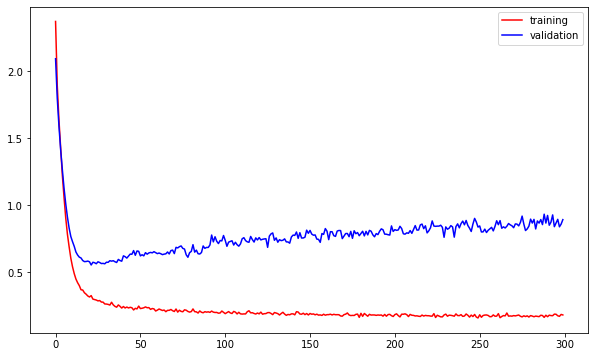

In [56]:
# plot the loss function per epoch
plt.plot(regr6.history.history['loss'],
         color='red',
        label='training')
plt.plot(regr6.history.history['val_loss'],
         color='blue',
        label='validation')
plt.legend()

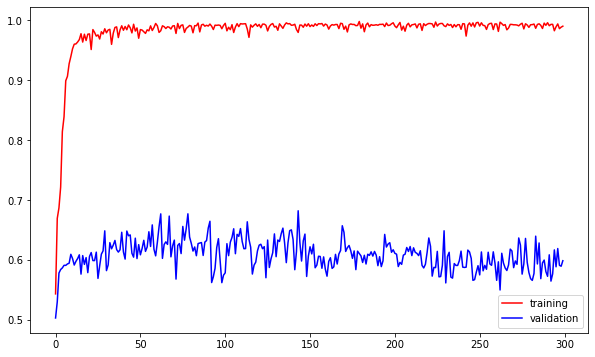

In [57]:
# plot the loss function per epoch
plt.plot(regr6.history.history['auc'],
         color='red',
        label='training')
plt.plot(regr6.history.history['val_auc'],
         color='blue',
        label='validation')
plt.legend()

In [58]:
print('The min validation loss of',
      np.min(regr6.history.history['val_loss']),
      ',\n was at epoch',
      np.argmin(regr6.history.history['val_loss']))

print('The max accuracy of',
      np.max(regr6.history.history['val_auc']),
      ',\n was at epoch',
      np.argmax(regr6.history.history['val_auc']))

The min validation loss of 0.5522218942642212 ,
 was at epoch 21
The max accuracy of 0.6820346713066101 ,
 was at epoch 143


,predictions,y_observed
377,3.750652e-03,0
1224,1.937360e-03,0
466,4.341175e-08,0
278,1.406372e-04,0
1416,2.628385e-11,0


y_observed
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: predictions, dtype: object

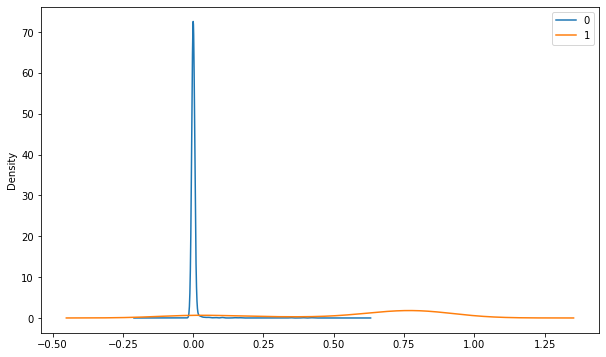

In [59]:
# make pandas dataframe of predicted probabilities and observed classes
df_preds = \
    pd.DataFrame({'predictions': regr6.predict(X_train_s).flatten(),
                  'y_observed': Y_train})
df_preds.head()
# Visualize distribution
df_preds.groupby('y_observed')['predictions'].plot.kde(legend=True)

<AxesSubplot:xlabel='predictions', ylabel='y_observed'>

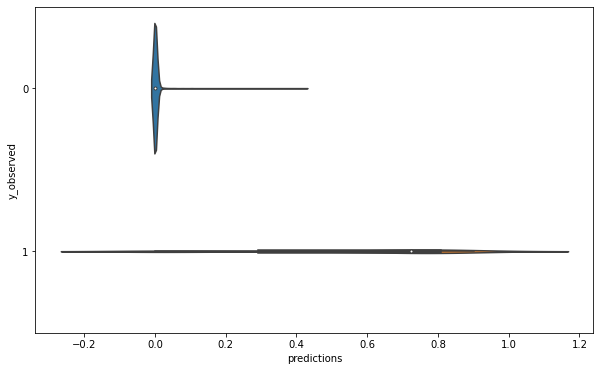

In [60]:
# show probability mass using seaborn
sns.violinplot(y="y_observed", 
               x="predictions",
               data=df_preds,
               orient='h')

<AxesSubplot:xlabel='predictions', ylabel='y_observed'>

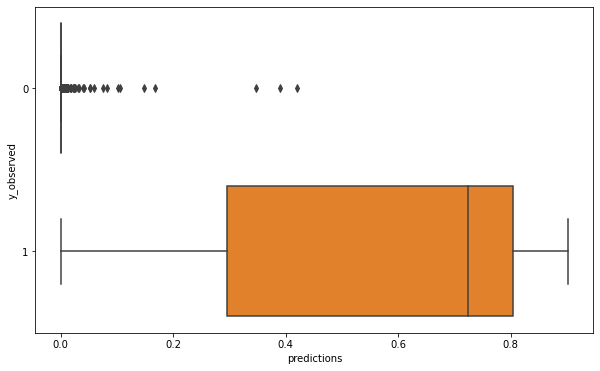

In [61]:
# show using a boxplot
sns.boxplot(y="y_observed", 
               x="predictions",
               data=df_preds,
               orient='h')

That looks better on the training error, we now have clear separation across the classes. However, the validation error wasn't very good as indicated by the loss function or the AUC across epochs. So we likely overfit. 

## More architecture changes

Perhaps we need a shallower network, with no dropout? We can run that experiment!

In [62]:
# build a simple linear model with l1 penalty using all vars as inputs
l1_penalty = 0.005


def build_model7():
    model = Sequential()
    model.add(Dense(64,
                    activation='relu',
                    kernel_regularizer=l1(l1_penalty),
                    input_dim=X_train.shape[1]))
    model.add(Dropout(0.5))
    model.add(Dense(1,
                    activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=metrics)
    return model

In [63]:
# fit this model/architecture to my data
regr7 = build_model7()
regr7.fit(X_train_s,
          Y_train,
          epochs=300,
          validation_split=0.2,
          verbose=0)

In [64]:
regr7.history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

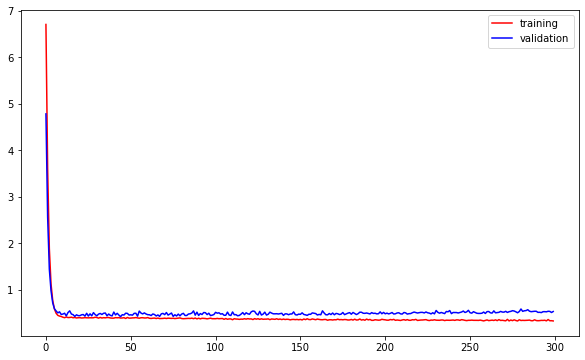

In [65]:
# plot the loss function per epoch
plt.plot(regr7.history.history['loss'],
         color='red',
        label='training')
plt.plot(regr7.history.history['val_loss'],
         color='blue',
        label='validation')
plt.legend()

,predictions,y_observed
377,0.061134,0
1224,0.214021,0
466,0.000349,0
278,0.021874,0
1416,0.000122,0


y_observed
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: predictions, dtype: object

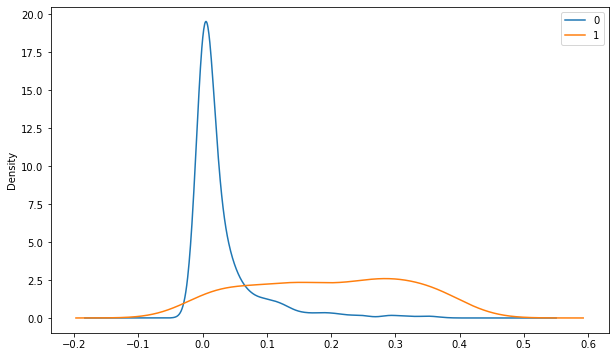

In [66]:
# make pandas dataframe of predicted probabilities and observed classes
df_preds = \
    pd.DataFrame({'predictions': regr7.predict(X_train_s).flatten(),
                  'y_observed': Y_train})
df_preds.head()
# Visualize distribution
df_preds.groupby('y_observed')['predictions'].plot.kde(legend=True)

<AxesSubplot:xlabel='predictions', ylabel='y_observed'>

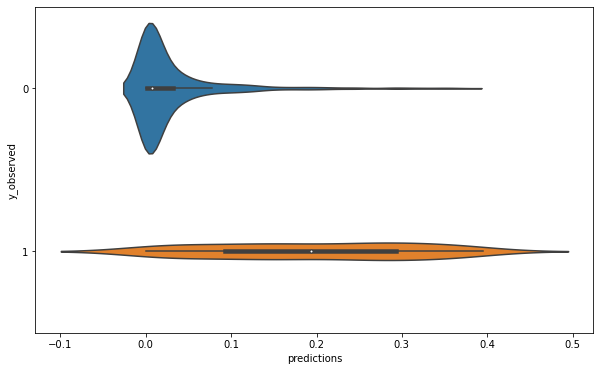

In [67]:
# show probability mass using seaborn
sns.violinplot(y="y_observed", 
               x="predictions",
               data=df_preds,
               orient='h')

<AxesSubplot:xlabel='predictions', ylabel='y_observed'>

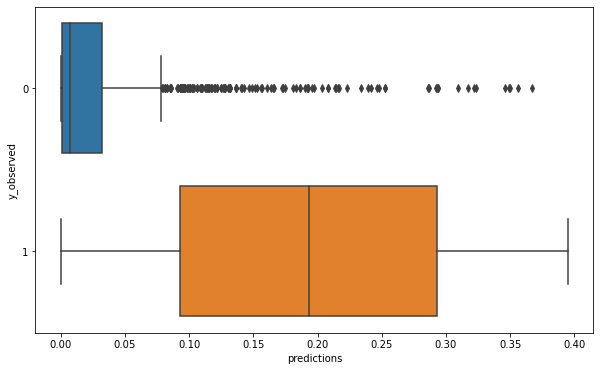

In [68]:
# show using a boxplot
sns.boxplot(y="y_observed", 
               x="predictions",
               data=df_preds,
               orient='h')

This is looking better in the training data. We have separation in the training data, but still no progress in the validation sets in terms of accuracy. The divergence between validation AUC and training AUC makes me think we are still overfitting. Let's examine the binary cross entropy value in the testing data to get a sense of what model is performing best.

In [69]:
results_df = \
    pd.DataFrame([regr1.evaluate(x=trans_1.transform(X_test),y=Y_test),
              regr2.evaluate(x=trans_1.transform(X_test),y=Y_test),
              regr3.evaluate(x=trans_1.transform(X_test),y=Y_test),
              regr4.evaluate(x=trans_1.transform(X_test),y=Y_test),
              regr5.evaluate(x=trans_1.transform(X_test),y=Y_test),
              regr6.evaluate(x=trans_1.transform(X_test),y=Y_test),
              regr7.evaluate(x=trans_1.transform(X_test),y=Y_test)])

10/10 [==============================] - 0s 1ms/step - loss: 0.4741 - accuracy: 0.9331 - auc: 0.6589


In [70]:
results_df.index = ['Model 1','Model 2','Model 3','Model 4','Model 5','Model 6','Model 7'] 
results_df.columns = ['loss','accuracy','auc']

In [71]:
results_df

,loss,accuracy,auc
Model 1,3.052028,0.878981,0.603770
Model 2,0.580483,0.929936,0.739395
Model 3,0.260817,0.933121,0.525272
Model 4,1.265520,0.929936,0.717292
Model 5,0.348917,0.933121,0.500000
Model 6,0.716741,0.923567,0.601333
Model 7,0.474120,0.933121,0.658947


Those are interesting results! 

Models 3 and 5 have the best cross entropy score - however, the predicted event probability is pretty different across these models. Model 2 had a narrow range of predicted probabilities mostly around the mean, so I thought we had overfit. However, the binary cross entropy is still better there. This is likely an artifact of the rare outcome - binary cross entropy summarizes the model error. 


## Try more architectures on your own

Experiment with the architecture to try to get a better fitting model on your own. 

        - Add more layers
        - Add more/less neurons per layer
        - Add an l2 penalty instead of l1
        - Add a combined l1/l2 penalty

## Conclusion

In this module, we have started our coverage of fitting classification models in deep learning. We used a rare outcome dataset, and we found it challenging to get a good model! This was likely due to the many potential predictors.

-  We learned how to implement a regression feed-forward NN using keras. 
-  We monitored our training error and our estimate of the generalization error via a validation dataset. 
-  We investigated some forms of regularization
-  And then we finally chose the 'best' model. 